# Imbalanced Data

- skip_exec: true


In [ ]:
import matplotlib.pyplot as plt
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)  # RGBA tuple with alpha=0

## Example Dataset


We are going to use a sample of the [adult census](https://www.openml.org/d/1590) dataset. For simplicity we will only use numberic features. We will also artificially make it very imbalanced (only ~1% of rows will be positive). The prediction task is to determine whether a person makes over 50K a year.


In [ ]:
xs, y = fetch_openml(data_id=1590, as_frame=True, return_X_y=True, parser="auto")
xs = xs.select_dtypes(include="number")
y = y.cat.codes


In [ ]:
xs, y = make_imbalance(xs, y, sampling_strategy={1: 400}, random_state=1)


In [ ]:
y.value_counts(normalize=True)


0    0.989349
1    0.010651
Name: proportion, dtype: float64

In [ ]:
xs


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,25,226802,7,0,0,40
1,38,89814,9,0,0,50
2,18,103497,10,0,0,30
3,34,198693,6,0,0,30
4,29,227026,9,0,0,40
...,...,...,...,...,...,...
37550,40,153372,10,0,0,50
37551,40,173651,10,0,0,40
37552,39,192251,9,0,0,40
37553,34,240252,14,0,0,40


In [ ]:
xs_train, xs_test, y_train, y_test = train_test_split(xs, y, stratify=y, random_state=0)


In [ ]:
y_test.value_counts()

0    9289
1     100
Name: count, dtype: int64

## Baseline Model


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9289
           1       0.71      0.15      0.25       100

    accuracy                           0.99      9389
   macro avg       0.85      0.57      0.62      9389
weighted avg       0.99      0.99      0.99      9389

ROC AUC Score: 0.692423296372053
Gini Score: 0.38484659274410604


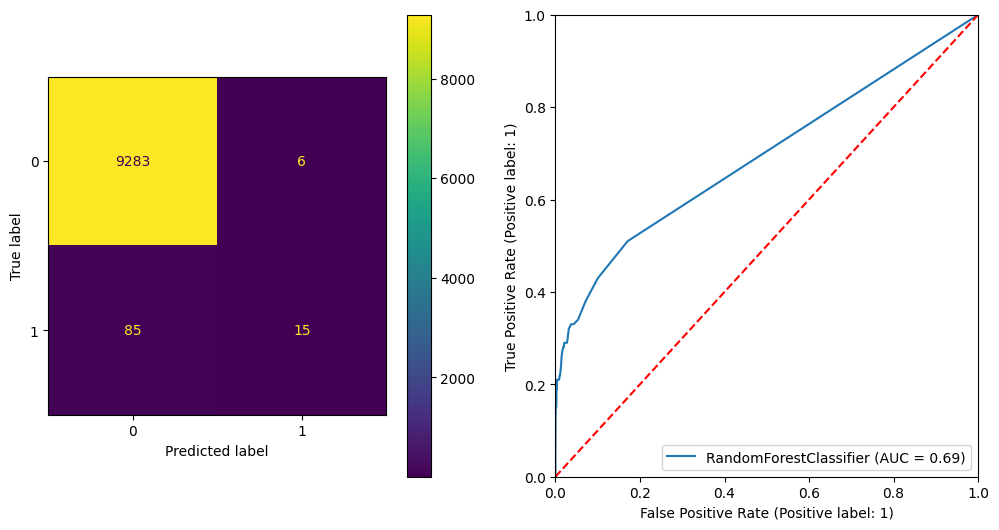

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(xs_train, y_train)

y_test_preds = rf_classifier.predict_proba(xs_test)[:, 1]

print(classification_report(y_test, (y_test_preds > 0.5).astype(int)))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_preds)}")
print(f"Gini Score: {2 * roc_auc_score(y_test, y_test_preds) - 1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, (y_test_preds > 0.5).astype(int))).plot(ax=axes[0])
RocCurveDisplay.from_estimator(rf_classifier, xs_test, y_test, ax=axes[1])
axes[1].set_xlim((0, 1))
axes[1].set_ylim((0, 1))
axes[1].plot([0, 1], [0, 1], linestyle="--", color="red")
plt.show()


## Ways to deal with imbalanced data


### Oversampling with SMOTE


SMOTE (Synthetic Minority Over-sampling Technique) is an algorithm designed to address class imbalance in classification problems by generating synthetic samples for the minority class. The main idea behind SMOTE is to create new samples by interpolating between existing minority class samples rather than simply duplicating them. This approach helps improve the classifier's ability to learn the decision boundary without leading to overfitting, as it introduces more diversity in the minority class.

Here's a step-by-step overview of how SMOTE works:

1. For each minority class sample, select `k` nearest neighbors from the minority class. `k` is a user-defined parameter.
2. Choose one of the `k` nearest neighbors randomly.
3. Generate a synthetic sample by interpolating between the selected sample and its chosen nearest neighbor:

   `synthetic_sample = original_sample + (random_neighbor - original_sample) * random_weight`

   Here, `random_weight` is a random number between 0 and 1. The interpolation process creates a new sample along the line segment connecting the two points.

4. Repeat steps 2 and 3 for a user-defined number of synthetic samples per original minority class sample. This parameter is also known as the oversampling percentage or the number of SMOTE neighbors.
5. Combine the original dataset with the generated synthetic samples to create a new, balanced dataset.

It's worth noting that SMOTE can be applied in various ways, such as:

- **Regular SMOTE**: The basic SMOTE algorithm as described above.
- **Borderline-SMOTE**: Focuses on generating synthetic samples near the decision boundary between the majority and minority classes, aiming to improve the classifier's performance on borderline instances.
- **SVM-SMOTE**: Uses an SVM classifier to identify support vectors in the minority class and generates synthetic samples based on the support vectors and their nearest neighbors.
- **K-Means SMOTE**: Applies K-means clustering to the minority class samples and generates synthetic samples based on the cluster centroids and their nearest neighbors.

When using SMOTE, it's important to apply the technique only to the training data and not the validation or test data, as doing so could lead to leakage and an overestimation of the classifier's performance.


#### Regular SMOTE


In [ ]:
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(xs_train, y_train)
y_train_resampled.value_counts()


0    27866
1    27866
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9289
           1       0.05      0.22      0.08       100

    accuracy                           0.95      9389
   macro avg       0.52      0.59      0.53      9389
weighted avg       0.98      0.95      0.96      9389

ROC AUC Score: 0.736138443320056
Gini Score: 0.4722768866401119


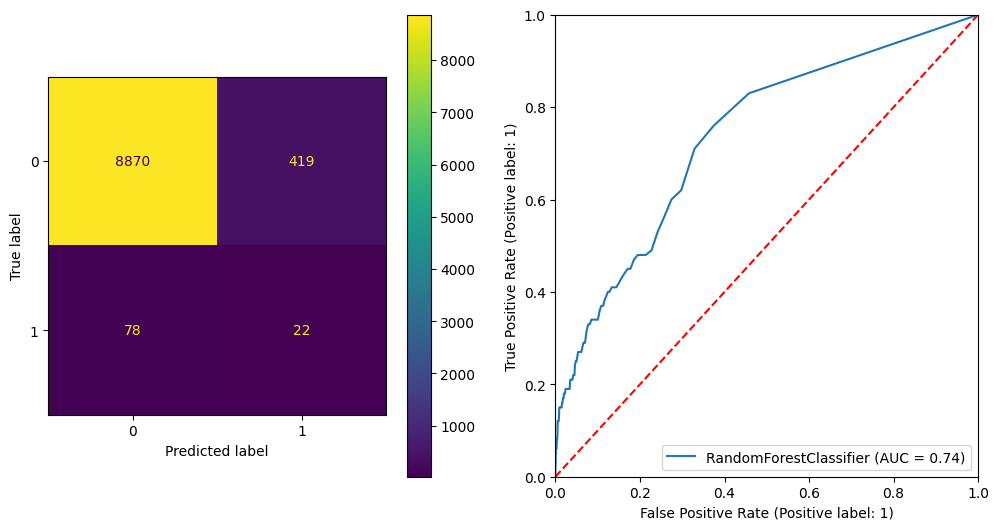

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

y_test_preds = rf_classifier.predict_proba(xs_test)[:, 1]

print(classification_report(y_test, (y_test_preds > 0.5).astype(int)))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_preds)}")
print(f"Gini Score: {2 * roc_auc_score(y_test, y_test_preds) - 1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, (y_test_preds > 0.5).astype(int))).plot(ax=axes[0])
RocCurveDisplay.from_estimator(rf_classifier, xs_test, y_test, ax=axes[1])
axes[1].set_xlim((0, 1))
axes[1].set_ylim((0, 1))
axes[1].plot([0, 1], [0, 1], linestyle="--", color="red")
plt.show()


#### Borderline SMOTE


In [ ]:
X_train_resampled, y_train_resampled = BorderlineSMOTE(random_state=42).fit_resample(xs_train, y_train)
y_train_resampled.value_counts()

0    27866
1    27866
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9289
           1       0.16      0.14      0.15       100

    accuracy                           0.98      9389
   macro avg       0.58      0.57      0.57      9389
weighted avg       0.98      0.98      0.98      9389

ROC AUC Score: 0.7377419528474539
Gini Score: 0.47548390569490784


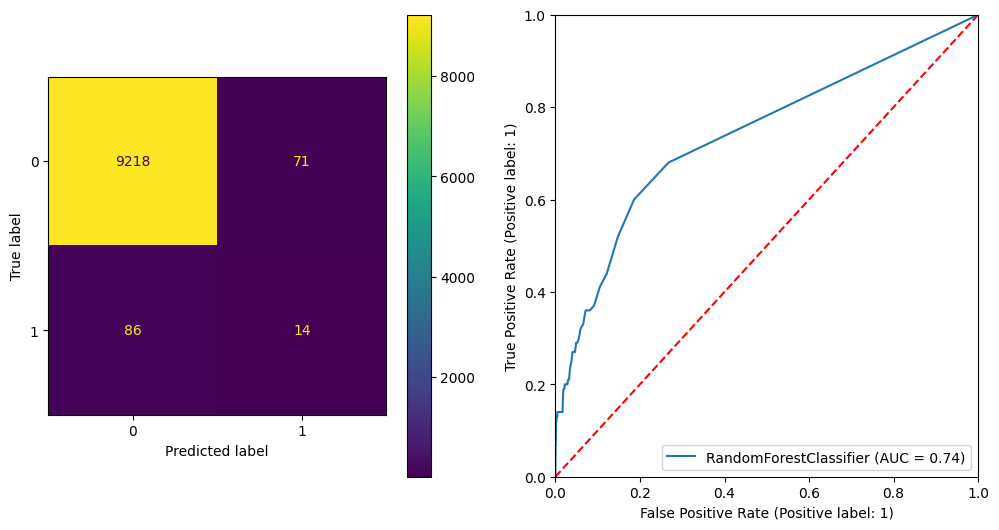

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

y_test_preds = rf_classifier.predict_proba(xs_test)[:, 1]

print(classification_report(y_test, (y_test_preds > 0.5).astype(int)))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_preds)}")
print(f"Gini Score: {2 * roc_auc_score(y_test, y_test_preds) - 1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, (y_test_preds > 0.5).astype(int))).plot(ax=axes[0])
RocCurveDisplay.from_estimator(rf_classifier, xs_test, y_test, ax=axes[1])
axes[1].set_xlim((0, 1))
axes[1].set_ylim((0, 1))
axes[1].plot([0, 1], [0, 1], linestyle="--", color="red")
plt.show()


### Adjusting class weights


The `class_weight` parameter in `RandomForestClassifier` is used to adjust the weights of classes during the training process. Assigning higher weights to the minority class helps the classifier pay more attention to these samples, potentially improving its performance on the minority class without needing to resample the data.

There are several ways to use the parameter:


#### 1. None (default)

When class_weight is set to None, all classes have equal weight. This means the classifier does not take class imbalance into account when making predictions.


#### 2. balanced

When `class_weight` is set to `'balanced'`, the weights for each class are computed based on the number of samples in each class. The weights are calculated as follows:

`class_weight = n_samples / (n_classes * np.bincount(y))`

This results in higher weights for minority classes and lower weights for majority classes. Consequently, the classifier will pay more attention to the minority class samples during training.


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9289
           1       0.67      0.12      0.20       100

    accuracy                           0.99      9389
   macro avg       0.83      0.56      0.60      9389
weighted avg       0.99      0.99      0.99      9389

ROC AUC Score: 0.6974808913768975
Gini Score: 0.394961782753795


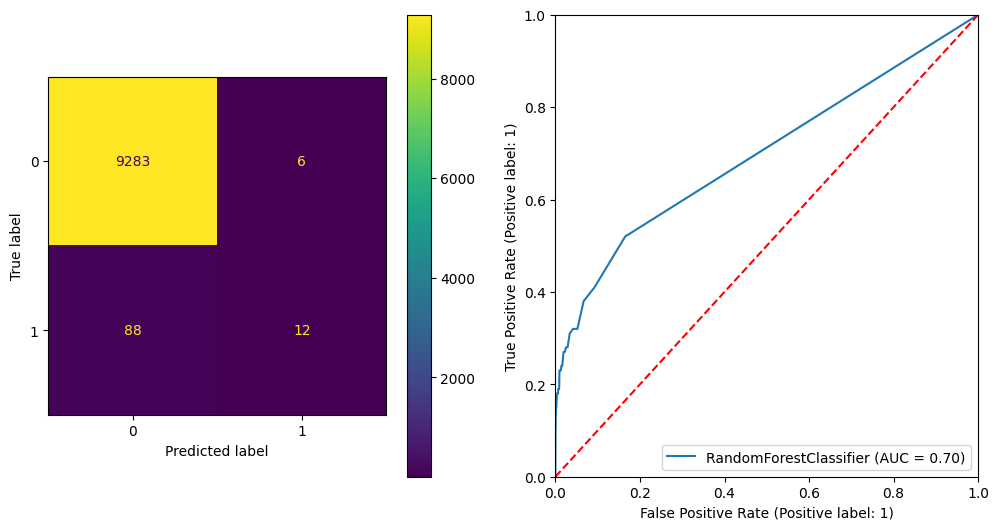

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_classifier.fit(xs_train, y_train)

y_test_preds = rf_classifier.predict_proba(xs_test)[:, 1]

print(classification_report(y_test, (y_test_preds > 0.5).astype(int)))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_preds)}")
print(f"Gini Score: {2 * roc_auc_score(y_test, y_test_preds) - 1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, (y_test_preds > 0.5).astype(int))).plot(ax=axes[0])
RocCurveDisplay.from_estimator(rf_classifier, xs_test, y_test, ax=axes[1])
axes[1].set_xlim((0, 1))
axes[1].set_ylim((0, 1))
axes[1].plot([0, 1], [0, 1], linestyle="--", color="red")
plt.show()

#### 3. balanced_subsample


The `balanced_subsample` mode is the same as `balanced` except that weights are computed based on the bootstrap sample for every tree grown.


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9289
           1       0.65      0.13      0.22       100

    accuracy                           0.99      9389
   macro avg       0.82      0.56      0.61      9389
weighted avg       0.99      0.99      0.99      9389

ROC AUC Score: 0.7098584347077188
Gini Score: 0.4197168694154376


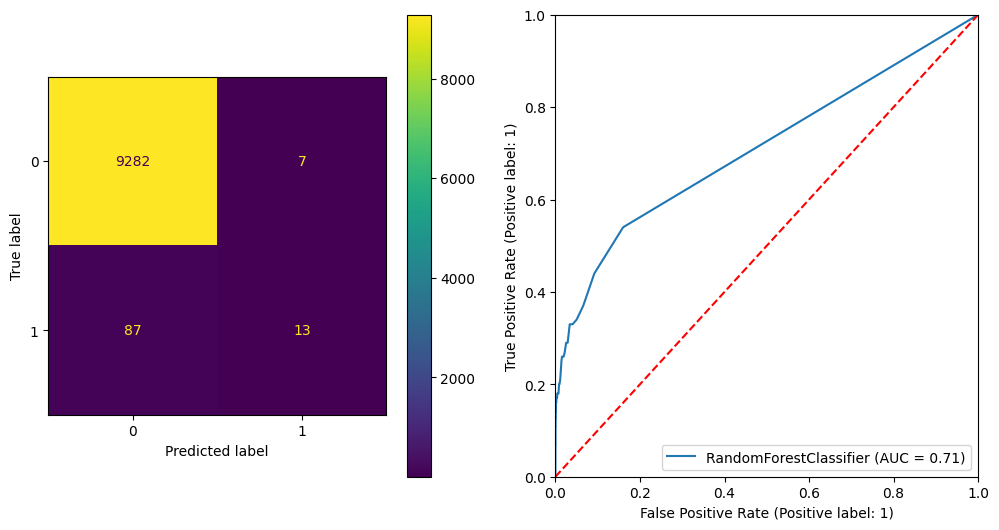

In [ ]:
rf_classifier = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")
rf_classifier.fit(xs_train, y_train)

y_test_preds = rf_classifier.predict_proba(xs_test)[:, 1]

print(classification_report(y_test, (y_test_preds > 0.5).astype(int)))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_test_preds)}")
print(f"Gini Score: {2 * roc_auc_score(y_test, y_test_preds) - 1}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(confusion_matrix(y_test, (y_test_preds > 0.5).astype(int))).plot(ax=axes[0])
RocCurveDisplay.from_estimator(rf_classifier, xs_test, y_test, ax=axes[1])
axes[1].set_xlim((0, 1))
axes[1].set_ylim((0, 1))
axes[1].plot([0, 1], [0, 1], linestyle="--", color="red")
plt.show()